# SVM Classifier

## Data Preprocessing

### Train-Test Split the Songs
It is important to create a train-test split of the songs *before* the splitting each song into three-second segments as to avoid mixing segments of the test songs into the actual training set.

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

df_songs = pd.read_csv('../features_30_sec.csv')
df_segments = pd.read_csv('../features_3_sec.csv')

X = df_songs
y = df_songs['label']

X_train_songs, X_test_songs, y_train_songs, y_test_songs = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_filenames = X_train_songs['filename']
test_filenames = X_test_songs['filename']


Given the song names in the train set and test set, it is necessary to get all 3-second segments corresponding to each song. In the CSV files, the full songs are in the format **[Genre].[Song Number].wav** whereas the segmented songs are in the format **[Genre].[Song Number].[Segment].wav**, so the segments can be extracted using some RegEx to get a mask.

In [4]:
train_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0]+ '.wav').isin(train_filenames)
test_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0]+ '.wav').isin(test_filenames)
df_train_segments = df_segments[train_mask].reset_index(drop=True)
df_test_segments = df_segments[test_mask].reset_index(drop=True)

### Drop Unnecessary Columns
The name of the file is obviously cheating, and all songs have roughly the same length (give or take a few frames), so the length is also an unnecessary column. The label is what is being predicted, so it is also dropped.

In [5]:
X_train_segments = df_train_segments.drop(columns=['filename', 'length', 'label'])
y_train_segments = df_train_segments['label']

## Model Selection

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(X_train_segments, y_train_segments, test_size=0.2)

svc = SVC(gamma='auto')
base_model = make_pipeline(StandardScaler(), svc)

remaining_features = list(X_train.columns)
best_score = 0
improvement = True

while improvement and len(remaining_features) > 0:
    improvement = False
    scores = []
    
    for feature in remaining_features:
        selected_features = [f for f in remaining_features if f != feature]
        X_train_selected = X_train[selected_features]
        X_val_selected = X_val[selected_features]
        
        base_model.fit(X_train_selected, y_train)
        val_score = base_model.score(X_val_selected, y_val)
        scores.append((val_score, feature))
    
    new_best_score, best_feature_to_remove = max(scores)
    
    if new_best_score > best_score:
        best_score = new_best_score
        remaining_features.remove(best_feature_to_remove)
        improvement = True
        print(f'Removed feature "{best_feature_to_remove}", new validation accuracy: {best_score}')

X_train_selected = X_train[remaining_features]
X_val_selected = X_val[remaining_features]

clf = base_model.fit(X_train_selected, y_train)

final_val_score = clf.score(X_val_selected, y_val)
print(f'Final validation accuracy: {final_val_score}')
print(f'Selected features: {remaining_features}')

KeyboardInterrupt: 

In [31]:
clf_final = base_model.fit(X_train_segments[remaining_features], y_train_segments)

In [32]:
X_test_segments = df_test_segments[remaining_features]
y_test_segments = df_test_segments['label']

y_pred = clf.predict(X_test_segments)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- mfcc15_var
- mfcc16_var
- mfcc17_var
- mfcc18_var
- mfcc1_var
- ...


In [24]:
def majority_vote(predictions):
    return predictions.mode().iloc[0]

Accuracy Score:
0.795


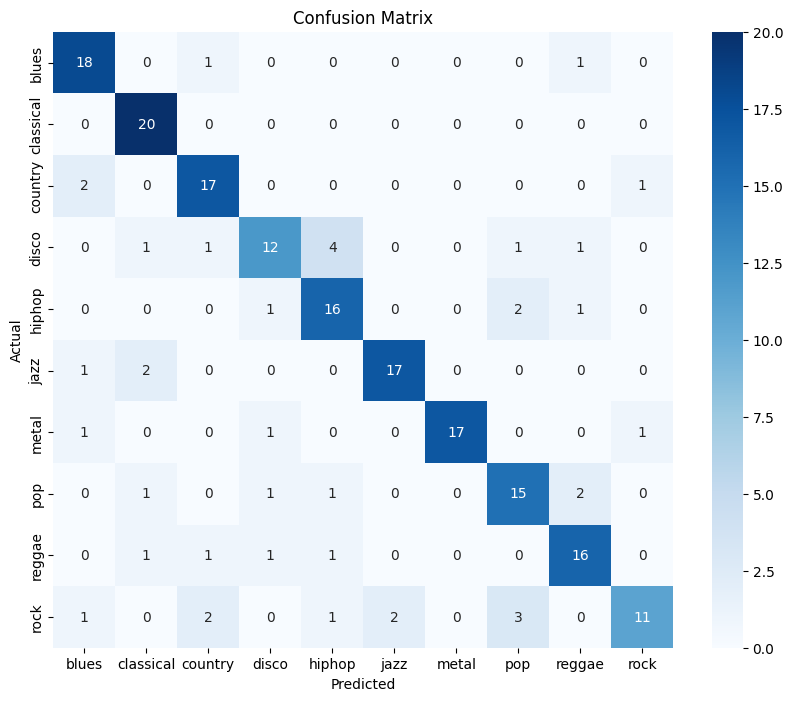

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt

df_test_segments['predicted_label'] = clf.predict(X_test_segments)

df_test_segments['song'] = df_test_segments['filename'].str.extract(r'(.*\.\d{5})')[0] + '.wav'
song_predictions = df_test_segments.groupby('song')['predicted_label'].apply(majority_vote)

song_true_labels = X_test_songs.set_index('filename').loc[song_predictions.index, 'label']

print("Accuracy Score:")
print(accuracy_score(song_true_labels, song_predictions))

cm = confusion_matrix(song_true_labels, song_predictions, labels=song_true_labels.unique())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=song_true_labels.unique(), yticklabels=song_true_labels.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
